In [12]:
import umap
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from src.models.spectrogram_vae import SpectrogramVAE
from src.utils import audio_to_spectrogram
from src.plot_utils import *

import seaborn as sns

In [13]:
sns.set(style='white')

In [14]:
DAFX_TO_USE = ['mda Delay', 'mda Overdrive', 'mda Ambience', 'mda RingMod', 'mda Combo', 'mda Dynamics']

In [15]:
NUM_EXAMPLES = 1_000
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_spectrogram_vae/hdx3y4ly/checkpoints/epoch=169-step=35530.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
OUT_DATA_DIR = f"/home/kieran/Level5ProjectAudioVAE/src/evaluation/data/dafx_latent_extraction"
FIG_DIR = f"/home/kieran/Level5ProjectAudioVAE/src/evaluation/figures/dafx_latent_extraction"

In [17]:
model = SpectrogramVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()

SpectrogramVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=37152, out_features=128, bias=True)
  (log_var): Linear(in_features=37152, 

In [18]:
from tqdm import tqdm

embeddings = []
full_features = []

for fx in DAFX_TO_USE:
    dafx = dafx_from_name(fx)
    dataset = get_audio_dataset(dafx, num_examples_per_epoch=NUM_EXAMPLES, effect_audio=True, dummy_setting=True)

    for x in tqdm(dataset):
        X = audio_to_spectrogram(signal=x,
                                 n_fft=model.hparams.n_fft,
                                 hop_length=model.hparams.hop_length,
                                 window_size=model.hparams.window_size).to(DEVICE)

        _, _, _, z = model(X)

        embeddings.append(z.cpu().detach().numpy())
        full_features.append(X.cpu().detach().ravel().numpy())

100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 2154.79it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 47656.39it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 46550.48it/s]



Loaded 88 files for train = 66.89 hours.


100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 2224.48it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 44788.10it/s]



Loaded 88 files for train = 66.89 hours.


100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 2213.84it/s]



Loaded 88 files for train = 66.89 hours.


100%|██████████| 1000/1000 [00:10<00:00, 94.19it/s] 


In [20]:
emb_data = np.array(embeddings).squeeze()
np.save(f"{OUT_DATA_DIR}/emb_data.npy", emb_data)

In [21]:
feats_data = np.array(full_features, dtype=np.float32)
np.save(f"{OUT_DATA_DIR}/feats_data.npy", feats_data)

In [22]:
emb_data.shape

(6000, 128)

In [23]:
umap_data = umap.UMAP(min_dist=0.2, metric='cosine').fit_transform(emb_data)
umap_labels = np.concatenate([[fx]*NUM_EXAMPLES for fx in DAFX_TO_USE]).squeeze()

In [43]:
le = LabelEncoder()
plot_labels = le.fit_transform(umap_labels)

In [25]:
num_fx = len(DAFX_TO_USE)

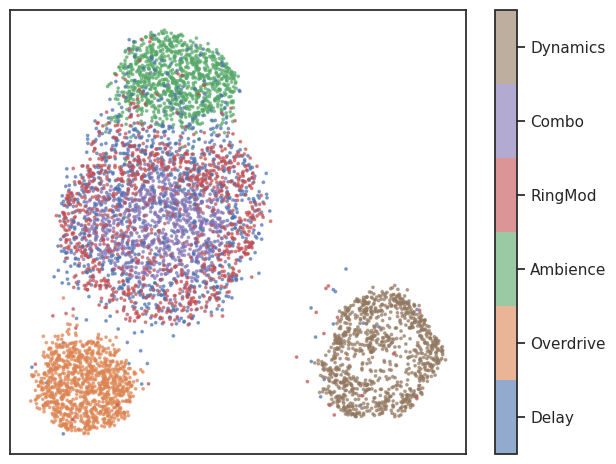

In [36]:
from matplotlib.colors import ListedColormap

my_colours = ListedColormap(sns.color_palette('deep', n_colors=6).as_hex())

fig, ax = plt.subplots(1)

plt.scatter(*umap_data.T, s=3, c=plot_labels, cmap=my_colours, alpha=.6)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(num_fx+1)-0.5)
cbar.set_ticks(np.arange(num_fx))
cbar.set_ticklabels([fx_name.split()[-1] for fx_name in DAFX_TO_USE])
# plt.title(f'Spectrogram VAE latent embeddings')
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/dafx_classes.pdf')

In [42]:
np.unique(plot_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([1000, 1000, 1000, 1000, 1000, 1000]))

In [45]:
le.classes_

array(['mda Ambience', 'mda Combo', 'mda Delay', 'mda Dynamics',
       'mda Overdrive', 'mda RingMod'], dtype='<U13')

In [46]:
from sklearn.decomposition import PCA

In [47]:
feats_data.shape

(6000, 264321)

In [48]:
pca = PCA(n_components=128)

transformed = pca.fit_transform(feats_data)

In [49]:
transformed.shape

(6000, 128)

In [50]:
np.save(f"{OUT_DATA_DIR}/pca_features.npy", transformed)

In [51]:
np.save(f"{OUT_DATA_DIR}/labels.npy", plot_labels)

In [52]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [55]:
mapping

{'mda Ambience': 0,
 'mda Combo': 1,
 'mda Delay': 2,
 'mda Dynamics': 3,
 'mda Overdrive': 4,
 'mda RingMod': 5}

In [56]:
import pickle

with open(f'{OUT_DATA_DIR}/label_mapping.pkl', 'wb') as handle:
    pickle.dump(mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)